### Modeling Introduction 

- Air France is looking to enhance its SEM campaigns in the US to boost market share and profits. They're exploring whether a uniform approach across search engines or tailored strategies would work better. The analysis will focus on optimizing keywords, adjusting tactics, and evaluating key performance indicators' impact on future strategies. Additionally, they're considering partnering with metasearch platforms like Kayak alongside traditional search engines. The aim is to provide useful insights and recommendations through R and Python analysis to improve SEM campaign effectiveness.


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part I: Imports and Data Check</h2>

In [1]:
import numpy             as np                       # mathematical essentials
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # essential graphical output
import seaborn as sns                                # enhanced graphical output



from sklearn.metrics import mean_squared_error       # Function to calculate mean squared error
from sklearn.metrics import r2_score                 # Function to compute the R^2 score
from sklearn.impute import SimpleImputer             # Provides a simple imputer class for filling missing values
from sklearn.preprocessing import StandardScaler     # Provides scaling functionality for standardizing data
from sklearn.model_selection import train_test_split # train/test split

from sklearn.linear_model import Lasso               # Class for building Lasso models
from sklearn.neighbors import KNeighborsRegressor    # Class for building KNN models
from sklearn.tree import DecisionTreeRegressor       # Class for building decision tree regression models

# setting pandas print options (optional)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Read training data
modeling_data = './train.csv'
df_train = pd.read_csv(modeling_data, header=0, index_col='entry_id')

# Read test data
testing_data = './test.csv'
df_test = pd.read_csv(testing_data, header=0, index_col='entry_id')


In [3]:
# Combine datasets
df_train['set'] = 'Not Kaggle'
df_test['set'] = 'Kaggle'

In [4]:
df_full = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_full.head()

,Publisher Name,Keyword,Match Type,Campaign,Keyword Group,Category,Bid Strategy,Status,Search Engine Bid,Clicks,Click Charges,Avg. Cost per Click,Impressions,Engine Click Thru %,Avg. Pos.,Trans. Conv. %,Total Cost/ Trans.,Amount,Total Cost,Total Volume of Bookings,set
0,Google - Global,fly to nice,Broad,Air France Global Campaign,Nice,nice,Position 1- 3,Unavailable,$1.25,15,$14.31,$0.95,380,3.95%,1.85,0.00%,$0.00,$0.00,$14.31,0.0,Not Kaggle
1,Yahoo - US,munich airport,Advanced,Western Europe Destinations,Munich,uncategorized,NaN,Paused,$6.25,1,$5.71,$5.71,25,4.00%,1.84,0.00%,$0.00,$0.00,$5.71,0.0,Not Kaggle
2,Overture - Global,chicago to paris,Advanced,Unassigned,Unassigned,paris,Position 1-2 Target,Sent,$0.45,14,$5.99,$0.43,"2,315",0.60%,4.48,0.00%,$0.00,$0.00,$5.99,0.0,Not Kaggle
3,Yahoo - US,discount international airfare,Advanced,Geo Targeted Los Angeles,Discount International Los Angeles,uncategorized,NaN,Paused,$6.25,9,$22.04,$2.45,86,10.47%,1.42,0.00%,$0.00,$0.00,$22.04,0.0,Not Kaggle
4,Google - US,cont:google_yearlong 2006::google|marrakech,NaN,Google_Yearlong 2006,Google|marrakech,uncategorized,NaN,Unavailable,$7.50,1,$4.63,$4.63,19,5.26%,1.53,0.00%,$0.00,$0.00,$4.63,0.0,Not Kaggle


In [5]:
# 'The list to remove $'
columns_to_clean = ['Search Engine Bid', 'Click Charges', 'Avg. Cost per Click', 
                    'Total Cost/ Trans.', 'Amount', 'Total Cost', 'Engine Click Thru %', 'Trans. Conv. %']

# 'The list to remove '%'
columns_to_clean_percentage = ['Engine Click Thru %', 'Trans. Conv. %']

# Remove '$'
df_full[columns_to_clean] = df_full[columns_to_clean].replace({'\$': ''}, regex=True)

# Remove '%'
df_full[columns_to_clean_percentage] = df_full[columns_to_clean_percentage].replace({'%': ''}, regex=True)


In [6]:
# The list to convert them to numeric
columns_to_convert = ['Search Engine Bid', 'Clicks', 'Click Charges', 
                      'Avg. Cost per Click', 'Trans. Conv. %', 'Impressions', 
                      'Total Cost/ Trans.', 'Amount', 'Total Cost', 'Engine Click Thru %']

# Convert them to numeric
df_full[columns_to_convert] = df_full[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Checking
df_full.dtypes

Publisher Name               object
Keyword                      object
Match Type                   object
Campaign                     object
Keyword Group                object
Category                     object
Bid Strategy                 object
Status                       object
Search Engine Bid           float64
Clicks                      float64
Click Charges               float64
Avg. Cost per Click         float64
Impressions                 float64
Engine Click Thru %         float64
Avg. Pos.                   float64
Trans. Conv. %              float64
Total Cost/ Trans.          float64
Amount                      float64
Total Cost                  float64
Total Volume of Bookings    float64
set                          object
dtype: object

<br>

In [7]:
#!##############################!#
#!# set your response variable #!#
#!##############################!#
y_variable = 'Total Volume of Bookings'

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part II: Data Preparation</h2><br>
Complete the following steps to prepare for model building. Note that you may add or remove steps as you see fit. Please see the assignment description for details on what steps are required for this project.
<br><br>
<h3>Base Modeling</h3>

### Exploratory Data Analysis and Data Preprocessing

#### In the EDA part

I will give an overview of the dataset, check descriptive statistics, and identify trends using data distributions.
First, I use df.info() to quickly identify the columns (features) and their types in the dataset. This is an important step in setting a course for subsequent exploratory data analysis (EDA).

The next step is to check the descriptive statistics using df_full.describe(). Indicators such as Max, Min, and std for each feature can be quantitatively calculated here. Finally, at the end of this part, a heat map is used to visualize the correlation between each feature. I will analyze these descriptive statistics together with the heatmap. This will help me to formulate a idea to properly perform the DP that I will do in the next part.

#### The DP part 

It is the checks for the presence of missing values for each feature, and then treats them.
If the dataset has missing values, I look at the histogram of the feature and check its distribution trend. If the shape of the distribution is normal, or if it is based on a normal distribution with skewed kurtosis and skewness, I do imputation using the median value of the 
distribution.

#### Feature Engineering part

Both intuitive taking advantage of domain knowledge and data-driven approaches are useful for feature engineering. This issue includes many formulas used especially in the digital marketing domain. We will therefore proceed with our analysis, taking into account their relationship to each other.

### Exploratory Data Analysis

In [8]:
# Checking the Data information
df_full.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Publisher Name            4510 non-null   object 
 1   Keyword                   4510 non-null   object 
 2   Match Type                4462 non-null   object 
 3   Campaign                  4510 non-null   object 
 4   Keyword Group             4510 non-null   object 
 5   Category                  4510 non-null   object 
 6   Bid Strategy              3286 non-null   object 
 7   Status                    4510 non-null   object 
 8   Search Engine Bid         4510 non-null   float64
 9   Clicks                    4429 non-null   float64
 10  Click Charges             4385 non-null   float64
 11  Avg. Cost per Click       4510 non-null   float64
 12  Impressions               3482 non-null   float64
 13  Engine Click Thru %       4510 non-null   float64
 14  Avg. Pos

In [9]:
df_full.describe()

,Search Engine Bid,Clicks,Click Charges,Avg. Cost per Click,Impressions,Engine Click Thru %,Avg. Pos.,Trans. Conv. %,Total Cost/ Trans.,Amount,Total Cost,Total Volume of Bookings
count,4510.000000,4429.000000,4385.000000,4510.000000,3482.000000,4510.000000,4510.000000,4510.000000,4478.000000,4272.000000,4385.000000,4410.000000
mean,5.434945,32.909460,44.652021,1.890860,193.340034,11.141457,1.929725,0.569266,13.577432,16.418411,44.652021,0.769841
std,3.301745,96.452893,116.078535,1.322372,241.668987,20.234530,1.075533,13.862477,78.411864,103.088540,116.078535,11.533078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.387500,1.000000,2.210000,0.830000,16.000000,1.530000,1.140000,0.000000,0.000000,0.000000,2.210000,0.000000
50%,6.250000,4.000000,6.240000,1.650000,85.000000,4.105000,1.590000,0.000000,0.000000,0.000000,6.240000,0.000000
75%,6.250000,17.000000,24.590000,2.660000,285.750000,10.917500,2.310000,0.000000,0.000000,0.000000,24.590000,0.000000
max,27.500000,997.000000,998.390000,10.000000,997.000000,200.000000,15.000000,900.000000,986.020000,991.100000,998.390000,439.000000


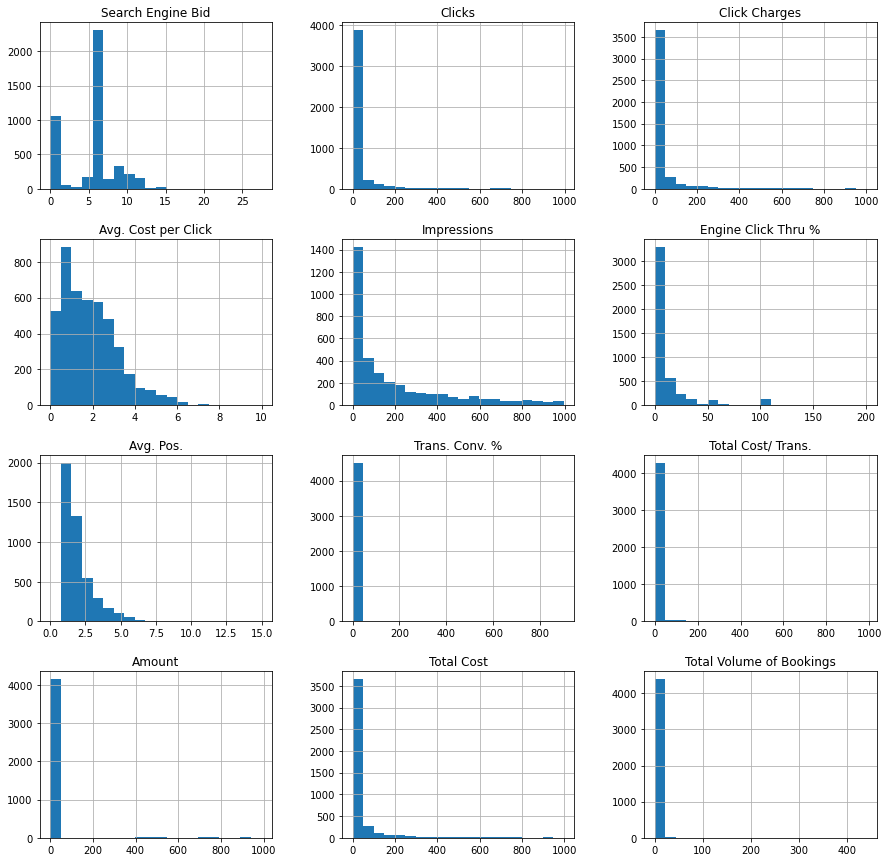

In [10]:
# Draw a histogram for each column to see the shape of the data distribution
df_full.hist(bins=20, figsize=(15, 15))
plt.show()


### Insights from Histgram

This is a histogram of each feature in the train data.It shows that all the features have strong peaks around 0 and 0.In particular, the target variables 'Total Volume of Bookings', 'Amount', 'Trans Conv %', and Total Cost/ Trans.' have almost the same shape.
Also, 'Clicks', 'Click Charges', and 'Total Cost' have the same shape.Here, let us check the formulas for each of them.
Click Charges'*'Avg. Cost per Click'='Click Charges'(='Total Cost') So the above columns are linked.

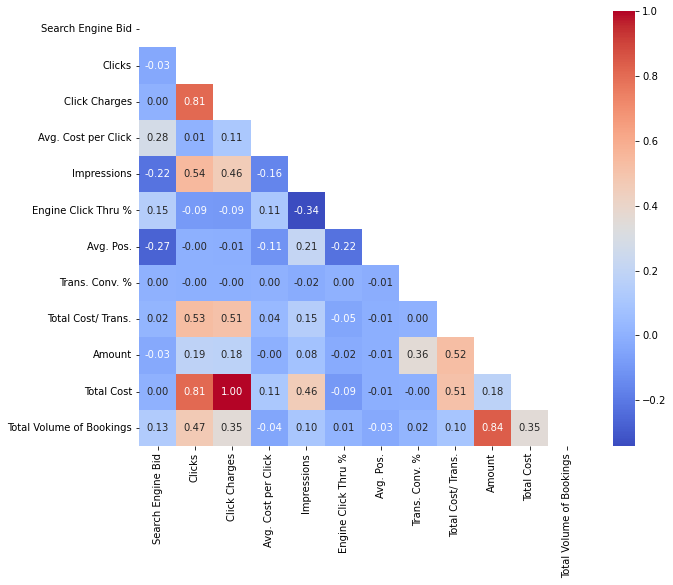

In [11]:
# Assuming df_full is your DataFrame
# Exclude non-numeric columns
df_numeric = df_full.select_dtypes(include=['float64', 'int64'])

# Now you can safely compute the correlation matrix and plot the heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df_numeric.corr(), dtype=bool))  # mask the upper half of the map
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.show()

#### Insights from Heat Map

This is a heat map showing the correlation coefficients between features in the train data.
We look at the relationship between 'Total Volume of Bookings' and the other relationships.
As mentioned in the discussion of the histogram, there is a strong correlation between 'Total Volume of Bookings' and 'Amount' at 0.84. On the other hand, the actual correlation coefficients for 'Trans Conv %' and 'Total Cost/ Trans.' are small.
The correlation coefficient between 'Total Cost' and 'Click Charges' is 1.
Furthermore, the correlation coefficients for 'Clicks', 'Click Charges', and 'Total Cost' are also high, which quantitatively supports what was stated in the histogram discussion.

<br><h3>Missing Value Analysis and Imputation</h3>

In [12]:
# Count the total number of missing values in each column : Before
missing_values = df_full.isnull().sum()
print(missing_values)

Publisher Name                 0
Keyword                        0
Match Type                    48
Campaign                       0
Keyword Group                  0
Category                       0
Bid Strategy                1224
Status                         0
Search Engine Bid              0
Clicks                        81
Click Charges                125
Avg. Cost per Click            0
Impressions                 1028
Engine Click Thru %            0
Avg. Pos.                      0
Trans. Conv. %                 0
Total Cost/ Trans.            32
Amount                       238
Total Cost                   125
Total Volume of Bookings     100
set                            0
dtype: int64


In [13]:
df_full.dtypes

Publisher Name               object
Keyword                      object
Match Type                   object
Campaign                     object
Keyword Group                object
Category                     object
Bid Strategy                 object
Status                       object
Search Engine Bid           float64
Clicks                      float64
Click Charges               float64
Avg. Cost per Click         float64
Impressions                 float64
Engine Click Thru %         float64
Avg. Pos.                   float64
Trans. Conv. %              float64
Total Cost/ Trans.          float64
Amount                      float64
Total Cost                  float64
Total Volume of Bookings    float64
set                          object
dtype: object

In [14]:
# Median Imputation to columns with missing values
median_imputer = SimpleImputer(strategy='median')
df_full[['Click Charges']] = median_imputer.fit_transform(df_full.copy()[['Click Charges']])

In [15]:
# Zero filling
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
columns_to_fill_zero = ['Clicks', 'Total Cost/ Trans.', 'Amount', 'Total Cost', 'Total Volume of Bookings']
df_full[columns_to_fill_zero] = zero_imputer.fit_transform(df_full[columns_to_fill_zero])

In [16]:
# Count the total number of missing values in each column : After
missing_values = df_full.isnull().sum()
print(missing_values)

Publisher Name                 0
Keyword                        0
Match Type                    48
Campaign                       0
Keyword Group                  0
Category                       0
Bid Strategy                1224
Status                         0
Search Engine Bid              0
Clicks                         0
Click Charges                  0
Avg. Cost per Click            0
Impressions                 1028
Engine Click Thru %            0
Avg. Pos.                      0
Trans. Conv. %                 0
Total Cost/ Trans.             0
Amount                         0
Total Cost                     0
Total Volume of Bookings       0
set                            0
dtype: int64


### Analysis of missing values for impressions -> Drop it from x features later

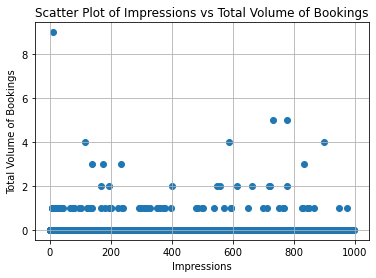

In [17]:
# scatter plot
plt.scatter(df_full['Impressions'], df_full['Total Volume of Bookings'])

# add labels and title
plt.xlabel('Impressions')
plt.ylabel('Total Volume of Bookings')
plt.title('Scatter Plot of Impressions vs Total Volume of Bookings')

# add grid
plt.grid(True)

# plot graph
plt.show()

- 'Scatter Plot of Impressions vs Total Volume of Bookings' 

This graph is a scatter plot showing the relationship between 'Impressions' and 'Total Volume of Bookings'.
Looking at the number of missing values per column shown above, 'Impressions' is 1028.
Since this is very large compared to the other columns, we examine it in detail in this graph.
The graph is not dependent on the number of impressions, and the points where 'Total Volume of Bookings' = 0 are all over the place.
Therefore, we believe that either impressions are not being measured well, or that there is almost no relationship with the 'Total Volume of Bookings'. We therefore exclude this column from the inputs to the model.

<br><h3>Feature Engineering</h3>

### 7 Feature candidates

### Net Revenue 
Net Revenue = Amount - Total Cost . 

This metric evaluates the overall contribution of publishers to a marketing campaign by subtracting the total cost incurred from the total amount generated. Essentially, it measures the profitability of the campaign after accounting for the expenses associated with advertising on various platforms or through different publishers. A higher net revenue indicates a more successful campaign in terms of generating income relative to the investment made.



### Probability of Action

Probability of Action = (Engine Click Thru % * Trans. Conv. %) / 10000

By multiplying the Engine Click Thru %  (Click Thorugh Rate - CTR) by the Trans. Conv. % (Transaction Conversion Rate - TCR), the Probability of Action (PoA) estimates the likelihood that a user who sees the ad will take the desired action, such as making a purchase. This metric helps advertisers and marketers evaluate the effectiveness of their campaigns in driving user actions and conversions. A higher PoA suggests that the campaign is more successful in prompting desired user behaviors.

### Number of Conversions

Number of Conversions Calculation = (Trans. Conv. % / 100) * Clicks.

estimate actual number of conversions from the % conversion rate and total number of clicks

### Keyword Efficiency Score (KES)

Keyword Efficiency Score (KES) = (Trans. Conv. %) / Avg. Cost per Click

Prioritize keywords with higher KES for optimization and budget allocation.

### Average Position Weighted by Clicks (APWC)

Average Position Weighted by Clicks (APWC) = Sum(Avg. Pos. * Clicks) / Sum(Clicks)

Goal: show avg and position  in the volume of clicks => shows  here most clicks are generated.

### Cost Efficiency Index (CEI)

(Engine Click Thru % * Trans. Conv. %) / Avg. Cost per Click

Show cost-efficient keywords by  CTR and conversion rates relative to cost

### Segment Performance Score (SPS) for Keyword Groups

Segment Performance Score (SPS) for Keyword Groups = Sum(Trans. Conv. % for each Keyword Group) / Count(Keywords in the Group)

Evaluates the collective performance of keywords within the same group or category.

In [18]:
# Net Revenue
df_full['Net Revenue'] = np.where(df_full['Amount'] == 0, 0, df_full['Amount'] - df_full['Total Cost'])

# Probability of Action
df_full['Probability of Action'] = (df_full['Engine Click Thru %'] * df_full['Trans. Conv. %']) / 10000

# Number of Conversions
df_full['Number of Conversions'] = (df_full['Trans. Conv. %'] / 100) * df_full['Clicks']

# Keyword Efficiency Score (KES)
df_full['Keyword Efficiency Score (KES)'] = df_full['Trans. Conv. %'] / df_full['Avg. Cost per Click']

# Average Position Weighted by Clicks (APWC)
df_full['APWC'] = (df_full['Avg. Pos.'] * df_full['Clicks']).sum() / df_full['Clicks'].sum()

# Cost Efficiency Index (CEI)
df_full['Cost Efficiency Index (CEI)'] = (df_full['Engine Click Thru %'] * df_full['Trans. Conv. %']) / df_full['Avg. Cost per Click']

# Segment Performance Score (SPS) for Keyword Groups
SPS_group = df_full.groupby('Keyword Group')['Trans. Conv. %'].sum() / df_full.groupby('Keyword Group')['Keyword'].count()
df_full['SPS for Keyword Groups'] = df_full['Keyword Group'].map(SPS_group)

# Check to be added new features
df_full.head()

,Publisher Name,Keyword,Match Type,Campaign,Keyword Group,Category,Bid Strategy,Status,Search Engine Bid,Clicks,Click Charges,Avg. Cost per Click,Impressions,Engine Click Thru %,Avg. Pos.,Trans. Conv. %,Total Cost/ Trans.,Amount,Total Cost,Total Volume of Bookings,set,Net Revenue,Probability of Action,Number of Conversions,Keyword Efficiency Score (KES),APWC,Cost Efficiency Index (CEI),SPS for Keyword Groups
0,Google - Global,fly to nice,Broad,Air France Global Campaign,Nice,nice,Position 1- 3,Unavailable,1.25,15.0,14.31,0.95,380.0,3.95,1.85,0.0,0.0,0.0,14.31,0.0,Not Kaggle,0.0,0.0,0.0,0.0,1.931474,0.0,0.307582
1,Yahoo - US,munich airport,Advanced,Western Europe Destinations,Munich,uncategorized,NaN,Paused,6.25,1.0,5.71,5.71,25.0,4.00,1.84,0.0,0.0,0.0,5.71,0.0,Not Kaggle,0.0,0.0,0.0,0.0,1.931474,0.0,0.000000
2,Overture - Global,chicago to paris,Advanced,Unassigned,Unassigned,paris,Position 1-2 Target,Sent,0.45,14.0,5.99,0.43,NaN,0.60,4.48,0.0,0.0,0.0,5.99,0.0,Not Kaggle,0.0,0.0,0.0,0.0,1.931474,0.0,0.159044
3,Yahoo - US,discount international airfare,Advanced,Geo Targeted Los Angeles,Discount International Los Angeles,uncategorized,NaN,Paused,6.25,9.0,22.04,2.45,86.0,10.47,1.42,0.0,0.0,0.0,22.04,0.0,Not Kaggle,0.0,0.0,0.0,0.0,1.931474,0.0,0.000000
4,Google - US,cont:google_yearlong 2006::google|marrakech,NaN,Google_Yearlong 2006,Google|marrakech,uncategorized,NaN,Unavailable,7.50,1.0,4.63,4.63,19.0,5.26,1.53,0.0,0.0,0.0,4.63,0.0,Not Kaggle,0.0,0.0,0.0,0.0,1.931474,0.0,0.000000


In [19]:
# Select only numeric columns from df_full 
df_numeric = df_full.select_dtypes(include=[np.number])

# Get correlation with target column (Total Volume of Bookings) only for numeric columns
correlation_with_rentals = df_numeric.corr()['Total Volume of Bookings'].round(decimals=2)

# Sort correlations in descending order
correlation_with_rentals_sorted = correlation_with_rentals.sort_values(ascending=False)

# print correlation
correlation_with_rentals_sorted

Total Volume of Bookings          1.00
Search Engine Bid                 0.13
Impressions                       0.10
Total Cost/ Trans.                0.09
Number of Conversions             0.07
Cost Efficiency Index (CEI)       0.04
Keyword Efficiency Score (KES)    0.03
Total Cost                        0.02
Probability of Action             0.02
SPS for Keyword Groups            0.02
Clicks                            0.02
Trans. Conv. %                    0.02
Click Charges                     0.02
Engine Click Thru %               0.01
Net Revenue                       0.00
Amount                            0.00
Avg. Pos.                        -0.03
Avg. Cost per Click              -0.04
APWC                               NaN
Name: Total Volume of Bookings, dtype: float64

array([[<AxesSubplot:title={'center':'Net Revenue'}>,
        <AxesSubplot:title={'center':'Probability of Action'}>,
        <AxesSubplot:title={'center':'Number of Conversions'}>],
       [<AxesSubplot:title={'center':'Keyword Efficiency Score (KES)'}>,
        <AxesSubplot:title={'center':'APWC'}>,
        <AxesSubplot:title={'center':'Cost Efficiency Index (CEI)'}>],
       [<AxesSubplot:title={'center':'SPS for Keyword Groups'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

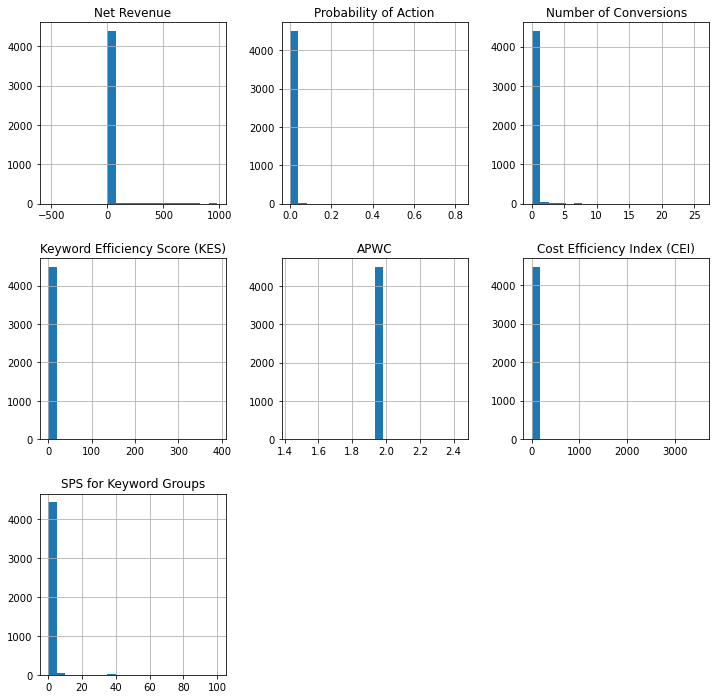

In [20]:
df_full[['Net Revenue', 'Probability of Action', 'Number of Conversions',
          'Keyword Efficiency Score (KES)', 'APWC', 'Cost Efficiency Index (CEI)',
          'SPS for Keyword Groups']].hist(bins=20, figsize=(12, 12))

### The histgram of New features
### The 7 Feature candidates -> Select 3 New Features to apply

These are histograms of the new feature candidates.We analyze them together with the correlation coefficients for the 'Total Volume of Bookings' above.First, these seven features also have a strong peak around 0.This is due to the influence of the trend of the train data set used in the calculation.
The 'Number of Conversions', 'Probability of Action', and 'SPS for Keyword Groups', which have correlation coefficients greater than 0, also have several small values other than 0 in the histogram.
We can expect that these are related to the bookings established.

### we finally select 'Number of Conversions','Probability of Action','SPS for Keyword Groups' as new features.

<br>

<br><h3>Standardization</h3>

In [21]:
## Standardization ##
# Instantiating a StandardScaler() object
scaler = StandardScaler()

# Selecting the features for standardization
features = df_full.columns.drop(['Publisher Name', 'Keyword', 'Match Type', 'Campaign', 'Keyword Group', 'Category', 'Bid Strategy', 'Status', 'Total Volume of Bookings', 'set'])

# Fitting the scaler to the features
scaler.fit(df_full[features])

# Transforming the features and assigning back to df_full
df_full.loc[:, features] = scaler.transform(df_full[features].copy())

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Data Partitioning</h2><br>
This is a very important step for your submission on Kaggle. Make sure to complete your data preparationbefore moving forward.
<br>
<br><h3>Separating the Kaggle Data</h3><br>

In [22]:
## parsing out testing data (needed for later) ##

# dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

<br><h3>Train-Test Split</h3><br>
Note that the following code will remove non-numeric features, keeping only integer and float data types. It will also remove any observations that contain missing values. This is to prevent errors in the model building process. 

In [23]:
df_full.columns

Index(['Publisher Name', 'Keyword', 'Match Type', 'Campaign', 'Keyword Group', 'Category', 'Bid Strategy', 'Status', 'Search Engine Bid', 'Clicks', 'Click Charges', 'Avg. Cost per Click', 'Impressions', 'Engine Click Thru %', 'Avg. Pos.', 'Trans. Conv. %', 'Total Cost/ Trans.', 'Amount', 'Total Cost', 'Total Volume of Bookings', 'set', 'Net Revenue', 'Probability of Action', 'Number of Conversions', 'Keyword Efficiency Score (KES)', 'APWC', 'Cost Efficiency Index (CEI)', 'SPS for Keyword Groups'], dtype='object')

In [24]:
#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
x_features = ['Publisher Name', 'Keyword', 'Match Type', 'Campaign', 'Keyword Group',
              'Category', 'Bid Strategy', 'Status', 'Search Engine Bid', 'Clicks', 'Click Charges',
              'Avg. Cost per Click', 'Engine Click Thru %', 'Avg. Pos.', 'Trans. Conv. %',
              'Total Cost/ Trans.', 'Amount', 'Total Cost', 
              'Probability of Action', 'Number of Conversions','SPS for Keyword Groups'] # this should be a final list # impression excluded



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# prepping data for train-test split
y_data = df[y_variable]


# removing non-numeric columns and missing values
x_data = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 1)

# storing remaining x_features after the step above
x_features = list(x_data.columns)


# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 702 )


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 4410
Features  (Columns): 27


Training Data (X-side)
----------------------
Observations (Rows): 3307
Features  (Columns): 13


Training Data (y-side)
----------------------
Feature Name:        Total Volume of Bookings
Observations (Rows): 3307


Testing Data (X-side)
---------------------
Observations (Rows): 1103
Features  (Columns): 13


Testing Data (y-side)
---------------------
Feature Name:        Total Volume of Bookings
Observations (Rows): 1103


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Candidate Modeling</h2><br>
Develop your candidate models below.

In [25]:
# Define model name and model correspondence
models = {
    "Lasso Regression": Lasso(),                         # Lasso Regression
    "K-Nearest Neighbors": KNeighborsRegressor(),        # K-Nearest Neighbors
    "Decision Tree Regressor": DecisionTreeRegressor()   # Decision Tree Regressor
}

# Loop and run for each model
for model_name, model in models.items():
    # Train model
    model.fit(x_train, y_train)

    # Predict with train data and test data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate R2 score 
    train_r2_score = r2_score(y_train, y_train_pred)
    test_r2_score = r2_score(y_test, y_test_pred)
    
    # Calculate Train-Test Gap
    model_gap = abs(train_r2_score - test_r2_score).round(4)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Print
    print(f"Model Name: {model_name}") # model name
    print(f"Train R2 Score: {train_r2_score}") # train r2 score
    print(f"Test R2 Score: {test_r2_score}") # test r2 score
    print(f"Train-Test Gap: {model_gap}") # train test gap
    print("Training RMSE:", train_rmse) # train rmse
    print("Test RMSE:", test_rmse) # test rmse

Model Name: Lasso Regression
Train R2 Score: 0.012058296980247851
Test R2 Score: 0.02505968201312425
Train-Test Gap: 0.013
Training RMSE: 12.644871522533904
Test RMSE: 6.718204559076825
Model Name: K-Nearest Neighbors
Train R2 Score: 0.5669477071836121
Test R2 Score: 0.6766110259443446
Train-Test Gap: 0.1097
Training RMSE: 8.371801705968197
Test RMSE: 3.8692501868139217
Model Name: Decision Tree Regressor
Train R2 Score: 1.0
Test R2 Score: -3.8114360030608188
Train-Test Gap: 4.8114
Training RMSE: 0.0
Test RMSE: 14.924560978431227


<br>
<h3>Model Results With Hyper-parameter tuning</h3><br>
Remember that some models have coefficients, visual outputs, etc. Make sure to analyze relevant results for the models you build.

### Lasso Regression with Hyper-parameter tuning

The Lasso Regression results show that the model is not performing as well as expected: both the Training Score and Test Score R^2 values are low, indicating limited explanatory power in the predictions; the Train-Test Gap is 0.029, which is relatively small, the problem of overtraining is less pronounced, but it is possible that the model does not fit the data well.

Also, the RMSEs of 12.5 (Training) and 6.62 (Test) are very different between the Training and Test RMSEs, indicating that the model may be over-trained. In other words, the model may fit the training data well, but perform poorly on unknown data.

In addition, Coefficients shows that the weights for some of the features are close to zero. This means that these features may have little impact on the model. This could mean that the selected features are not very useful for prediction or that the model could not find appropriate regularization parameters.


Training Score (R^2): 0.029449665817766868
Test Score (R^2): 0.051321743003639564
Train-Test Gap: 0.0219
Training RMSE: 12.5330794762688
Test RMSE: 6.627102403320672
Coefficients:
Feature 0: 1.3252386189357601
Feature 1: -0.0
Feature 2: 0.0
Feature 3: -0.543590930811673
Feature 4: 0.0
Feature 5: -0.0
Feature 6: 0.0
Feature 7: 0.9250151880877294
Feature 8: -0.0
Feature 9: 0.0
Feature 10: 0.0
Feature 11: 0.14099148185767268
Feature 12: 0.0


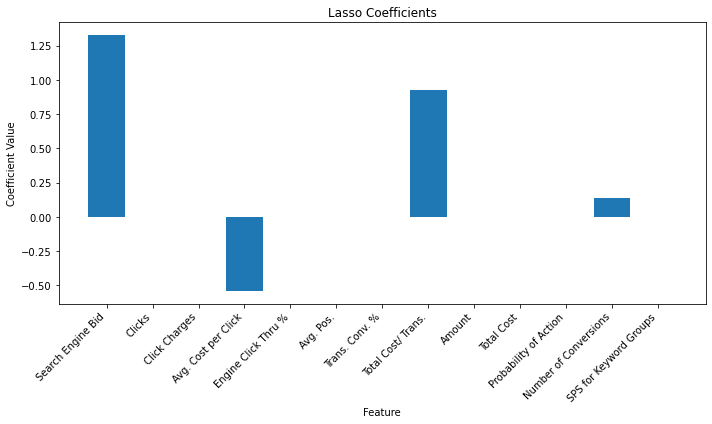

Index(['Search Engine Bid', 'Clicks', 'Click Charges', 'Avg. Cost per Click', 'Engine Click Thru %', 'Avg. Pos.', 'Trans. Conv. %', 'Total Cost/ Trans.', 'Amount', 'Total Cost', 'Probability of Action', 'Number of Conversions', 'SPS for Keyword Groups'], dtype='object')

Best Parameters:
alpha: 0.40046313368206166

Test Score: 0.051321743003639564


In [26]:
# Manual hyperparameter tuning
best_params = {
    'alpha': 0.40046313368206166 
}

# Create the final model with the best parameters
not_best_model = Lasso(**best_params, random_state=42)

# Fit the final model to the training data
not_best_model.fit(x_train, y_train)



# Predict on the training data using the final model
not_best_model_train_pred = not_best_model.predict(x_train)

# Predict on the test data using the final model
not_best_model_test_pred = not_best_model.predict(x_test)

# Calculate R^2 score on training data
train_score = r2_score(y_train, not_best_model_train_pred)

# Calculate R^2 score on test data
test_score = r2_score(y_test, not_best_model_test_pred)

# Calculate the difference between training and test scores
score_difference = abs(train_score - test_score).round(4)



# Output training score
print("Training Score (R^2):", train_score)

# Output test score
print("Test Score (R^2):", test_score)

# Output the difference between training and test scores
print("Train-Test Gap:", score_difference)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, not_best_model_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, not_best_model_test_pred))

print("Training RMSE:", train_rmse)

print("Test RMSE:", test_rmse)

# Output coefficients
coefficients = not_best_model.coef_
print("Coefficients:")
for i, coef in enumerate(coefficients):
    print(f"Feature {i}: {coef}")

# Get feature names
feature_names = x_train.columns

# Visualize coefficients
plt.figure(figsize=(10, 6)) # set the size
plt.bar(feature_names, coefficients) # set graph 
plt.xlabel('Feature') # set xlabel
plt.ylabel('Coefficient Value') # set ylabel
plt.title('Lasso Coefficients') # set title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(feature_names)
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print("\nTest Score:", test_score)




### Decision Tree Model with Hyper-parameter tuning

The results for the Decision Tree model show that the model performs better than Lasso Regression, with higher R^2 values for both Training Score and Test Score and better explanatory power for the predictions. relatively large, suggesting that an over-training problem may be present.

The RMSE is 9.22 (Training) and 3.78 (Test). This indicates that the Decision Tree model shows relatively good prediction accuracy on both training and test data.

However, the following are possible reasons why the RMSE is still a little high It is likely that the Decision Tree model can model nonlinear relationships between features, but overly deep trees are causing over-training.

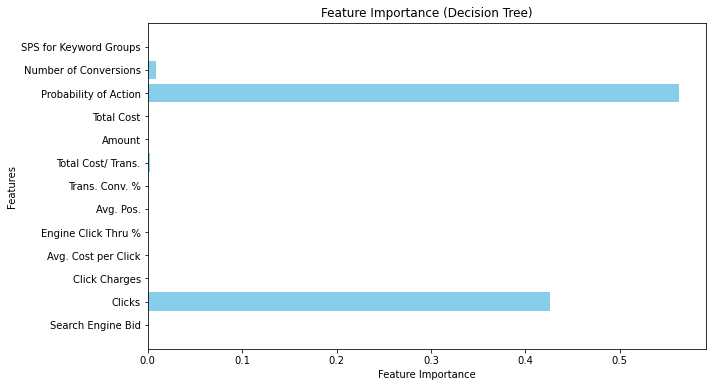

Best Parameters:
max_depth: 12
min_samples_split: 2
min_samples_leaf: 9
Training Score (R^2): 0.47406956358348706
Test Score (R^2): 0.6904424280735648
Train-Test Gap: 0.2164
Training RMSE: 9.225988615406811
Test RMSE: 3.7856017500672996
Best Parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 9}


In [27]:
# Manual hyperparameter tuning
best_params = {
    'max_depth': 12,
    'min_samples_split': 2,
    'min_samples_leaf': 9
}

# Create the final model with the best parameters
not_best_model = DecisionTreeRegressor(**best_params)

# Fit the final model to the training data
not_best_model.fit(x_train, y_train)

# Predict on the test data using the final model
model_pred = not_best_model.predict(x_test)

# Calculate R^2 score
test_score = r2_score(y_test, model_pred)

# Visualize feature importances
feature_importances = not_best_model.feature_importances_
plt.figure(figsize=(10, 6)) # set the size 
plt.barh(x_train.columns, feature_importances, color='skyblue') # set the gragh
plt.xlabel('Feature Importance') # set the xlable
plt.ylabel('Features') # set ylable
plt.title('Feature Importance (Decision Tree)') # set title
plt.show()

print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")


# Predict on the training data using the final model
not_best_model_train_pred = not_best_model.predict(x_train)

# Predict on the test data using the final model
not_best_model_test_pred = not_best_model.predict(x_test)

# Calculate R^2 score on training data
train_score = r2_score(y_train, not_best_model_train_pred)

# Calculate R^2 score on test data
test_score = r2_score(y_test, not_best_model_test_pred)

# Calculate the difference between training and test scores
score_difference = abs(train_score - test_score).round(4)

# Output training score
print("Training Score (R^2):", train_score)

# Output test score
print("Test Score (R^2):", test_score)

# Output the difference between training and test scores
print("Train-Test Gap:", score_difference)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, not_best_model_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, not_best_model_test_pred))

print("Training RMSE:", train_rmse)

print("Test RMSE:", test_rmse)


print("Best Parameters:", best_params)


### KNN Model with Hyper-parameter tuning

The results for the KNN model show a Training Score of 1.0 and a Test Score of 0.78. The Train-Test Gap is 0.21, indicating that the model is over-trained.

It also shows that the RMSE is lower than the other two models. The low RMSE for both the training and test data suggests that the KNN model fits the data well and has good generalization ability.

A possible reason for the high performance of the KNN model can be attributed to its features: the KNN has the ability to capture nonlinear relationships and can be flexibly adapted to the data. This makes the model particularly effective even when the data is high dimensional.

Training Score (R^2): 1.0
Test Score (R^2): 0.7837227313857982
Train-Test Gap: 0.2163
Training RMSE: 0.0
Test RMSE: 3.164241674191449
Best Parameters: {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'kd_tree'}


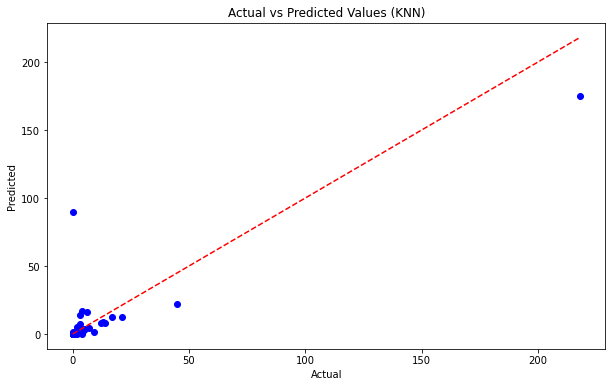

In [28]:
# Manual hyperparameter tuning
best_params = {
    'n_neighbors': 20,
    'weights': 'distance',
    'algorithm': 'kd_tree'
}
# Create the final model with the best parameters
best_model = KNeighborsRegressor(**best_params)

# Fit the final model to the training data
best_model.fit(x_train, y_train)


# Predict on the training data using the final model
best_model_train_pred = best_model.predict(x_train)

# Predict on the test data using the final model
model_pred = best_model.predict(x_test)

# Calculate R^2 score on training data
train_score = r2_score(y_train, best_model_train_pred)

# Calculate R^2 score on test data
test_score = r2_score(y_test, model_pred)

# Calculate the difference between training and test scores
score_difference = abs(train_score - test_score).round(4)

# Output training score
print("Training Score (R^2):", train_score)

# Output test score
print("Test Score (R^2):", test_score)

# Output the difference between training and test scores
print("Train-Test Gap:", score_difference)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, best_model_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, model_pred))

print("Training RMSE:", train_rmse)

print("Test RMSE:", test_rmse)

print("Best Parameters:", best_params)





# Visualize predicted vs actual values
plt.figure(figsize=(10, 6)) # set the size
plt.scatter(y_test, model_pred, color='blue') # set the graph
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Actual') # set xlabel
plt.ylabel('Predicted') # set ylable
plt.title('Actual vs Predicted Values (KNN)') # set title
plt.show()


### Final Model Selection
We finally select KNN as our final model. 
The main reason is that the KNN model has the lowest RMSE on the test set.
And,the smallest average error between predicted and measured values. 
This indicates that the KNN model better fits the characteristics of the data.
In addition, the KNN model showed higher predictive performance than the other two models, with an R^2 score of 0.78 on the test set.
This is better than the results of the other models, suggesting that it is able to make more accurate predictions.
Additionally, it is important to note that there were no excessive differences between the model's training and test scores.
The gap between the training score (R2 = 1.0) and the test score (R2 = 0.78) for the KNN model was 0.21.
This suggests that the problem of overtraining is relatively suppressed.
This indicates that over-training is likely occurring.
### For those reasons, we select the KNN model as our final model on above cell.

<br>
<h3>Residual Analysis</h3><br>

In [29]:
## Residual Analysis ##

# organizing residuals
model_residuals = {"True"            : y_test,
                   "Predicted"       : model_pred
                  }


# converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)


# checking results
model_resid_df.head(n = 5)


#!###########################!#
#!# add more code as needed #!#
#!###########################!#



,True,Predicted
3605,0.0,0.000000
1191,0.0,0.000000
4217,13.0,8.532682
4001,0.0,0.000000
1405,0.0,0.000000


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part IV: Preparing Submission File for Kaggle</h2><br>
The code below will store the predicted values for each of the models above.

In [30]:
# x-data
x_data_kaggle = kaggle_data[x_features].copy()


# y-data
y_data_kaggle = kaggle_data[y_variable]


# Fitting model from above to the Kaggle test data
kaggle_predictions = best_model.predict(x_data_kaggle)

<br>
<h3>Creating the Kaggle File</h3><br>

In [31]:
## Kaggle Submission File ##

# organizing predictions
model_predictions = {"Total Volume of Bookings" : kaggle_predictions}


# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)


#!######################!#
#!# name the .csv file #!#
#!######################!#

# sending predictions to .csv
#model_pred_df.to_csv(path_or_buf = "./Team3_ing_our_best_submission.csv",
#                     index       = True,
#                     index_label = 'entry_id')

### Reference
- OpenAI. (2024). ChatGPT (3.5) [Large language model]. https://chat.openai.com : 
  https://chat.openai.com/share/b27a508d-01e8-40f4-8c74-2612a8c520b2

<br>

<br>